In [2]:
# Import supporting libraries
import pandas 
import numpy
import sklearn.impute as impute
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as modelsel
import sklearn.tree as tree
import sklearn.metrics as metrics
import sklearn.svm as SVC
import pydotplus
import collections
import sklearn
from sklearn.utils import resample
from sklearn.feature_selection import SequentialFeatureSelector
import os
import warnings
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.neural_network import MLPClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
from sklearn.metrics import  ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

In [3]:
# LOAD DATA
filename = 'events.csv'
df = pandas.read_csv(filename)
df = df.drop(['id_odsp', 'id_event', 'sort_order', 'event_type','event_type2','text', 'side', 'event_team', 
              'opponent','player','player2','player_in','player_out'], axis=1)
df

,time,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,2,6.0,2.0,0,9.0,2.0,1,1.0,0
1,4,NaN,NaN,0,NaN,NaN,0,NaN,0
2,4,NaN,NaN,0,NaN,NaN,0,NaN,0
3,7,NaN,NaN,0,NaN,NaN,0,NaN,0
4,7,NaN,NaN,0,2.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...
941004,92,NaN,NaN,0,2.0,NaN,0,NaN,0
941005,93,NaN,NaN,0,NaN,NaN,0,NaN,0
941006,93,8.0,2.0,0,9.0,1.0,1,3.0,0
941007,94,NaN,NaN,0,4.0,NaN,0,NaN,0


In [4]:
#==================: PRE-PROCESS DATA SET :=========================
# Drop nan (Not a number) in the data set. The number of missing observations is
# much larger than the remaining ones, so imputation does not work in this case.
# Since the raw data set is large, we remove the missing values.
df = df.dropna()

# Drop duplicated samples
df = df.drop_duplicates()

In [5]:
# Drop values in shot_place with values 1, 2, 6, 8, 9, and 10 since these vaues imply no goal.

L= [1,2,6,8,9,10]
df = df[~df.shot_place.isin(L)]

# Drop values in shot_outcome with values 2, 3 since these vaues imply no goal.
O= [2,3]
df = df[~df.shot_outcome.isin(O)]

# Export data set after cleaning missing values
df.to_excel('cleaned_dataSPDO.xlsx')

# Check the number of rows in the data set
len_df = len(df.index)
df

,time,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
13,17,4.0,1.0,1,9.0,2.0,1,1.0,0
18,25,7.0,4.0,0,3.0,1.0,1,1.0,0
22,26,5.0,1.0,0,3.0,3.0,2,1.0,0
26,29,5.0,1.0,1,3.0,1.0,1,1.0,0
49,48,11.0,1.0,0,3.0,1.0,1,1.0,0
...,...,...,...,...,...,...,...,...,...
940682,84,5.0,1.0,0,11.0,1.0,4,1.0,0
940722,37,4.0,1.0,1,9.0,1.0,0,1.0,0
940791,21,11.0,1.0,0,12.0,3.0,2,1.0,0
940832,53,7.0,4.0,0,9.0,1.0,0,1.0,0


In [6]:
# Define predictor features and target features for original dataset
X=df.drop(["is_goal"],axis=1)
y=df["is_goal"]

In [7]:
# Count the number of observations (0s and 1s) in the target varible
df_is_goal_1 = df[df["is_goal"]==1]
df_is_goal_0 = df[df["is_goal"]==0]

In [8]:
print(len(df_is_goal_0))
print(len(df_is_goal_1))
print(len(df))

18720
13683
32403


In [9]:
#==============: IMPLEMENT BALANCING TECHNIQUES TO THE DATASET :================
#  Technique 1: Oversampling (technique 2 is combined in the function of training the model)
over_sample_1 = resample(df_is_goal_1,n_samples = len(df_is_goal_0)) 
# The number of observations 0 is bigger than observation 1. 
# So choose len(df_is_goal_0) is 50% of the number of the total observations in the target variable. 
df_oversample = pandas.concat([df_is_goal_0, over_sample_1]) # New data set after oversampling

df_oversample = df_oversample.sample(frac = 1)                          # Sampling without replacement (basically reshuffling data)

# Define predictor features and target features for oversampling dataset
X_oversample =df_oversample.drop(["is_goal"],axis=1)
y_oversample =df_oversample["is_goal"]

Text(0.5, 1.0, 'Before oversampling')

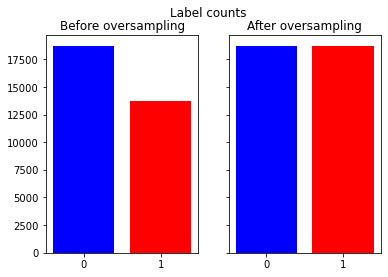

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
fig.suptitle('Label counts')
ax2.bar(x=["0","1"],height=y_oversample.value_counts(),color=["blue","red"])
ax1.bar(x=["0","1"],height=y.value_counts(),color=["blue","red"])

ax2.set_title("After oversampling")
ax1.set_title("Before oversampling")

In [11]:
## Data Normalization: Because feature values are categorical, we don't do data normalization. 

In [12]:
# Define Sequential feature selection method
def feature_sel(model_name, n_selected_features, X, y):  
    #Feature selection
    sfs = SequentialFeatureSelector(model_name, n_features_to_select = n_selected_features)   # Sequential model of sklearn is used
    features= X.columns.values
    sfs.fit(X,y)
    support=sfs.get_support()  
    selected_features=features*support
    selected_features=list(selected_features)
    selected_features=[a for a in selected_features if a!=""]
    print(selected_features)
    return(selected_features)

In [14]:
pip install nbimporter


Note: you may need to restart the kernel to use updated packages.
